In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, mean_absolute_error
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, r2_score

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

import pickle

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../feature_selection/data/raw_selected_data.csv', index_col=0)
df.head()

,Amount,nCount,Weight,Volume,OKVED_395.0,OKVED_0.0,BeginMonth_1,OKVED_296.0,BeginMonth_2,UnitTypeCategory_2,...,OKVED_317.0,OKVED_373.0,ActivityArea_64.0,ActivityArea_95.0,ActivityArea_42.0,ActivityArea_72.0,OKVED_11.0,ActivityArea_121.0,BinNclick,percent_nClick
0,-0.148895,-0.181508,-0.292518,-0.279925,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
1,-0.148895,-0.181508,-0.292518,-0.077765,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0.0
2,-0.148895,-0.156237,-0.292518,-0.178845,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0.0
3,-0.148895,-0.181508,-0.292518,-0.279925,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
4,-0.148895,-0.181508,-0.292518,-0.077765,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0.0


Text(0.5, 1.0, 'Распределение таргетов')

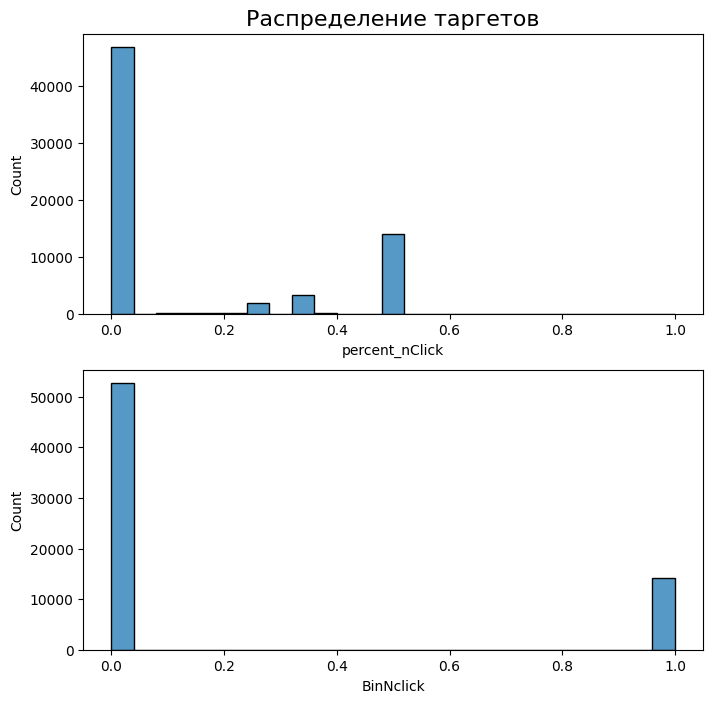

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
sns.histplot(
    data=df,
    x='percent_nClick',
    bins=25,
    #kde=True,
    ax=axes[0]
);
sns.histplot(
    data=df,
    x='BinNclick',
    bins=25,
    ax=axes[1]
);
axes[0].set_title('Распределение таргетов', fontsize=16)

## Регрессия

In [4]:
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['percent_nClick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

### LightGBM

In [6]:
def objective_lgbm_reg(trial):
    # Подбираемые параметры
    params={'verbosity':-1,
            'lambda_l2':trial.suggest_float('lambda_l2', 0.1, 1),
            'max_depth':trial.suggest_int('max_depth', 5, 100),
            'num_leaves':trial.suggest_int('num_leaves', 5, 105, step=10),
            'learning_rate':trial.suggest_float('learning_rate',0.001, 0.901, step=0.01),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.8 , step=0.1)
            }

    # Обучаем модель
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_lgbm_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_lgbm_reg.optimize(objective_lgbm_reg, n_trials=100)

[I 2024-05-20 08:53:56,195] A new study created in memory with name: no-name-e154dd2d-e267-49a1-971e-75af8cd7652d
[I 2024-05-20 08:53:57,666] Trial 0 finished with value: 0.023639147568570423 and parameters: {'lambda_l2': 0.5238357897446168, 'max_depth': 24, 'num_leaves': 95, 'learning_rate': 0.311, 'bagging_fraction': 0.6}. Best is trial 0 with value: 0.023639147568570423.
[I 2024-05-20 08:53:58,592] Trial 1 finished with value: 0.03304769291553773 and parameters: {'lambda_l2': 0.5566405788839436, 'max_depth': 63, 'num_leaves': 25, 'learning_rate': 0.031, 'bagging_fraction': 0.5}. Best is trial 0 with value: 0.023639147568570423.
[I 2024-05-20 08:53:59,336] Trial 2 finished with value: 0.03678032824682928 and parameters: {'lambda_l2': 0.17383751712476242, 'max_depth': 34, 'num_leaves': 5, 'learning_rate': 0.061, 'bagging_fraction': 0.7}. Best is trial 0 with value: 0.023639147568570423.
[I 2024-05-20 08:54:00,218] Trial 3 finished with value: 0.034070028203928064 and parameters: {'lam

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\1341559625.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

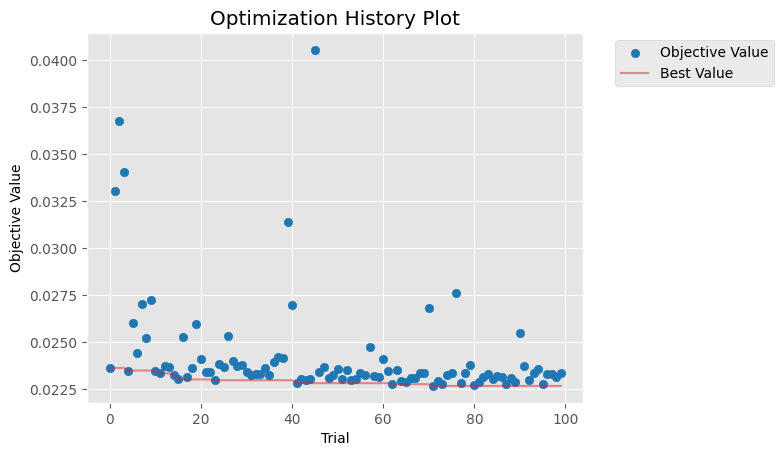

In [7]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_reg)

In [8]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_reg.trials)))
print('Лучший трайл:')
trial = study_lgbm_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MSE: 0.02268077907219852
  Параметры: 
    lambda_l2: 0.8197447022989721
    max_depth: 80
    num_leaves: 105
    learning_rate: 0.451
    bagging_fraction: 0.6


In [9]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_reg = LGBMRegressor(verbose=-1,**params)
lgbm_reg.fit(X_train, y_train)

# Предсказание
y_pred_lgbm_reg = lgbm_reg.predict(X_test)

# Считаем основные метрики
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm_reg)
#mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm_reg)
r2_lgbm = r2_score(y_test, y_pred_lgbm_reg)

# Выводим основные метрики
print(f"MSE LightGBM: {round(mse_lgbm, 3)}")
#print(f"MAE LightGBM: {round(mae_lgbm, 3)}")
print(f"R2_score LightGBM: {round(r2_lgbm, 3)*100}%")

MSE LightGBM: 0.023
R2_score LightGBM: 46.400000000000006%


In [10]:
# Сохраним модель
with open(r'models/lgb_reg_model.pkl', 'wb') as file:
    pickle.dump(lgbm_reg, file)

### CatBoost

In [11]:
def objective_catb_reg(trial):
    # Подбираемые параметры
    params={
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучаем модель
    optuna_model = CatBoostRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_catb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_catb_reg.optimize(objective_catb_reg, n_trials=100)

[I 2024-05-20 08:56:13,011] A new study created in memory with name: no-name-6edd41c5-9a03-4b8e-a186-91a08036e73e
[I 2024-05-20 08:56:27,051] Trial 0 finished with value: 0.028853484182022614 and parameters: {'iterations': 744, 'learning_rate': 0.03799643606977152, 'depth': 7, 'l2_leaf_reg': 2.8074019154687805e-07, 'random_strength': 1.1147297772842992e-08, 'bagging_temperature': 6.25431384130763, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial 0 with value: 0.028853484182022614.
[I 2024-05-20 08:56:32,382] Trial 1 finished with value: 0.038572759915762284 and parameters: {'iterations': 236, 'learning_rate': 0.004789013797084975, 'depth': 9, 'l2_leaf_reg': 2.3154376061086174e-05, 'random_strength': 6.043379144288542e-08, 'bagging_temperature': 9.395116944446123, 'od_type': 'Iter', 'od_wait': 10}. Best is trial 0 with value: 0.028853484182022614.
[I 2024-05-20 08:57:08,860] Trial 2 finished with value: 0.026350225800479136 and parameters: {'iterations': 803, 'learning_rate': 0.0353

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\1089751886.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_catb_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

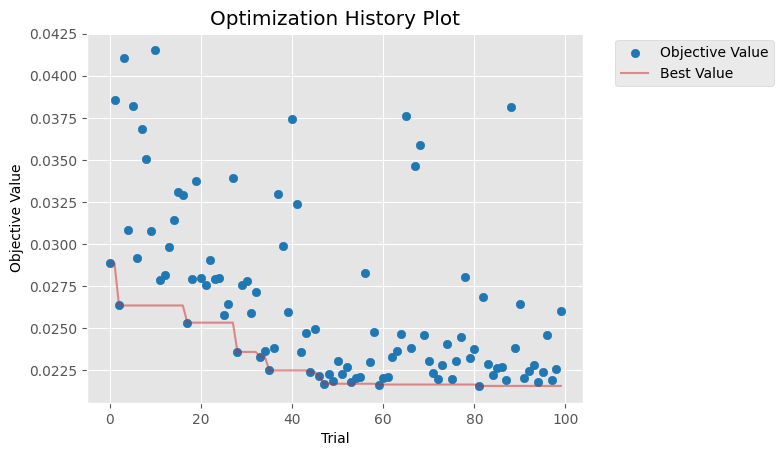

In [12]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_catb_reg)

In [13]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_reg.trials)))
print('Лучший трайл:')
trial = study_catb_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший MSE: 0.021568634544433772
  Параметры: 
    iterations: 854
    learning_rate: 0.09980267263179536
    depth: 10
    l2_leaf_reg: 1.41436513172635e-07
    random_strength: 1.4369109148812566e-05
    bagging_temperature: 8.07613643866234
    od_type: Iter
    od_wait: 11


In [14]:
# Обучим модель на получившихся параметрах
params = trial.params
catb_reg = CatBoostRegressor(verbose=0,**params)
catb_reg.fit(X_train, y_train)

# Предсказание
y_pred_catb_reg = catb_reg.predict(X_test)

# Считаем основные метрики
mse_catb = mean_squared_error(y_test, y_pred_catb_reg)
r2_catb = r2_score(y_test, y_pred_catb_reg)

# Выводим основные метрики
print(f"MSE CatBoost: {round(mse_catb, 3)}")
print(f"R2_score CatBoost: {round(r2_catb, 3)*100}%")

MSE CatBoost: 0.022
R2_score CatBoost: 49.1%


In [15]:
# Сохраним модель
with open(r'models/catb_reg_model.pkl', 'wb') as file:
    pickle.dump(catb_reg, file)

### XGBoost

In [17]:
def objective_xgb_reg(trial):
    # Подбираемые параметры
    params={
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучаем модель
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train, y_train)
    
    # Предсказание
    y_pred = optuna_model.predict(X_test)
    
    # Оценка предсказания
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Создаем сессию для минимизации выбранной метрики
study_xgb_reg = optuna.create_study(direction='minimize')
# Запускаем нашу сессию оптимизации
study_xgb_reg.optimize(objective_xgb_reg, n_trials=50)

[I 2024-05-20 09:41:37,828] A new study created in memory with name: no-name-9951f5a9-fb30-45c5-8679-115cbb306df6
[I 2024-05-20 09:43:16,560] Trial 0 finished with value: 0.02185009299400844 and parameters: {'learning_rate': 0.13672127358835232, 'n_estimators': 724, 'max_depth': 7, 'subsample': 0.9807631532147626, 'colsample_bytree': 0.8891715152216656}. Best is trial 0 with value: 0.02185009299400844.
[I 2024-05-20 09:44:40,064] Trial 1 finished with value: 0.0251090613779273 and parameters: {'learning_rate': 0.09907848168928908, 'n_estimators': 996, 'max_depth': 5, 'subsample': 0.6143681699627328, 'colsample_bytree': 0.5072863368350093}. Best is trial 0 with value: 0.02185009299400844.
[I 2024-05-20 09:45:43,808] Trial 2 finished with value: 0.02144306830770386 and parameters: {'learning_rate': 0.19118831116606427, 'n_estimators': 326, 'max_depth': 9, 'subsample': 0.8774432319921557, 'colsample_bytree': 0.9006326144397119}. Best is trial 2 with value: 0.02144306830770386.
[I 2024-05-

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\984470995.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_xgb_reg)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

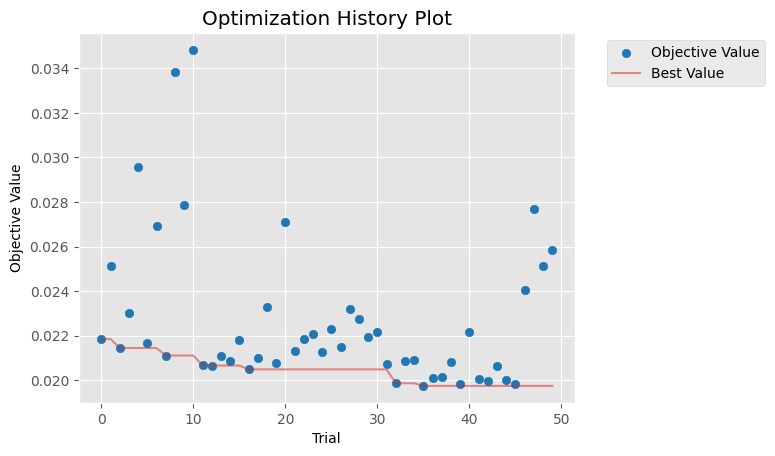

In [18]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_xgb_reg)

In [19]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_reg.trials)))
print('Лучший трайл:')
trial = study_xgb_reg.best_trial

print('  Лучший MSE: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 50
Лучший трайл:
  Лучший MSE: 0.01974209550331834
  Параметры: 
    learning_rate: 0.18575665672808334
    n_estimators: 643
    max_depth: 9
    subsample: 0.9473365477589708
    colsample_bytree: 0.627396102553168


In [20]:
# Обучим модель на получившихся параметрах
params = trial.params
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

# Предсказание
y_pred_xgb_reg = xgb_reg.predict(X_test)

# Считаем основные метрики
mse_xgb = mean_squared_error(y_test, y_pred_xgb_reg)
r2_xgb = r2_score(y_test, y_pred_xgb_reg)

# Выводим основные метрики
print(f"MSE XGBoost: {round(mse_xgb, 3)}")
print(f"R2_score XGBoost: {round(r2_xgb, 3)*100}%")

MSE XGBoost: 0.02
R2_score XGBoost: 53.400000000000006%


In [21]:
# Сохраним модель
with open(r'models/xgb_reg_model.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

## Классификация

In [22]:
# Выделяем таргет
X = df.drop(['percent_nClick', 'BinNclick'], axis=1)
y = df['BinNclick']

# Разделяем данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Посмотрим распределение меток по данным
print(f'Распределение в обучающих данных: {y_train.value_counts()}')
print(f'Распределение в тестовых данных: {y_test.value_counts()}')

Распределение в обучающих данных: BinNclick
0    42056
1    11431
Name: count, dtype: int64
Распределение в тестовых данных: BinNclick
0    10648
1     2724
Name: count, dtype: int64


In [23]:
sc=StandardScaler()
sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

### LightGBM

In [24]:
def objective_lgbm_class(trial):
    """Определение целевой функции для LightGBM Classification"""
    
    # Задаем сетку параметров
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "depth": trial.suggest_int("depth", 4, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "force_col_wise": True,
        'verbose': -1,
    }

    # Обучение модели
    optuna_model = LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_lgbm_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_lgbm_class.optimize(objective_lgbm_class, n_trials=100)

[I 2024-05-20 10:53:59,074] A new study created in memory with name: no-name-988f857d-9455-4c81-9b69-e454791dc637
[I 2024-05-20 10:54:01,297] Trial 0 finished with value: 0.5810877021068104 and parameters: {'depth': 4, 'lambda_l1': 7.907847684691255e-05, 'lambda_l2': 0.47108648377762846, 'num_leaves': 81, 'feature_fraction': 0.45954536177111927, 'bagging_fraction': 0.8139812967091693, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 0 with value: 0.5810877021068104.
[I 2024-05-20 10:54:03,599] Trial 1 finished with value: 0.607436021245775 and parameters: {'depth': 6, 'lambda_l1': 1.1496545343884859e-07, 'lambda_l2': 4.648401565729811, 'num_leaves': 92, 'feature_fraction': 0.8355549540321616, 'bagging_fraction': 0.831806809833022, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 1 with value: 0.607436021245775.
[I 2024-05-20 10:54:04,613] Trial 2 finished with value: 0.4550930996714129 and parameters: {'depth': 4, 'lambda_l1': 0.01338730397665512, 'lambda_l2': 7.020

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\682897915.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

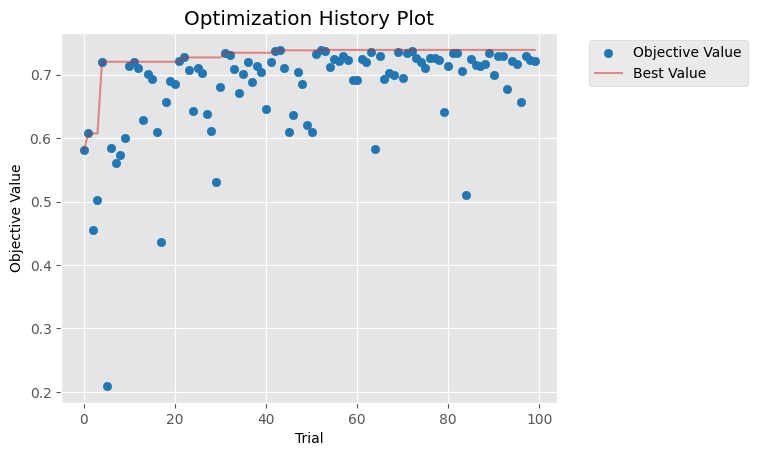

In [25]:
# Посмотрим на процесс подбора параметров на графике
plot_optimization_history(study_lgbm_class)

In [32]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_lgbm_class.trials)))
print('Лучший трайл:')
trial = study_lgbm_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 100
Лучший трайл:
  Лучший F1-score: 0.7390822434050099
  Параметры: 
    depth: 10
    lambda_l1: 3.728813376807362e-06
    lambda_l2: 2.999478380741427e-08
    num_leaves: 235
    feature_fraction: 0.9189152132121106
    bagging_fraction: 0.9551103670758846
    bagging_freq: 7
    min_child_samples: 5


In [33]:
# with open("models/lgbm_class_model.pkl", "rb") as f:
#     lgbm_class = pickle.load(f)

In [34]:
# Обучим модель на получившихся параметрах
params = trial.params
lgbm_class = LGBMClassifier(verbose=-1,**params)
lgbm_class.fit(X_train, y_train)

# Предсказание
y_pred_lgbm_class = lgbm_class.predict(X_test)
f1_lgbm = f1_score(y_test, y_pred_lgbm_class)

# Выводим основные метрики
print(f"F1-score LightGBM: {round(f1_lgbm, 3)}")
print('Classification report LightGBM:')
print(classification_report(y_test, y_pred_lgbm_class))

F1-score LightGBM: 0.739
Classification report LightGBM:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10648
           1       0.93      0.61      0.74      2724

    accuracy                           0.91     13372
   macro avg       0.92      0.80      0.84     13372
weighted avg       0.91      0.91      0.90     13372



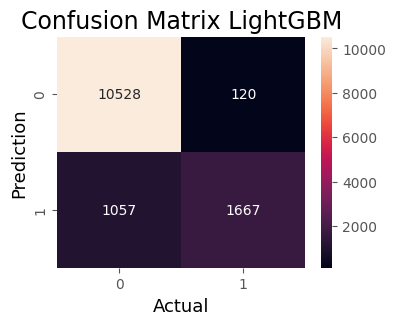

In [35]:
# Посмотрим на матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_lgbm = confusion_matrix(y_test, y_pred_lgbm_class)
sns.heatmap(con_mat_lgbm,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix LightGBM', fontsize=17)
plt.show()

In [36]:
# Сохраним модель
with open(r'models/lgb_class_model.pkl', 'wb') as file:
    pickle.dump(lgbm_class, file)

### CatBoost

In [37]:
def objective_catb_class(trial):
    """Определение целевой функции для CatBoost Classification"""

    # Подбираемые параметры
    params = {
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': 0,
    }

    # Обучение модели
    optuna_model = CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_catb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_catb_class.optimize(objective_catb_class, n_trials=50)

[I 2024-05-20 10:59:25,486] A new study created in memory with name: no-name-c0a156bb-ad1d-4de8-8157-91f59c1dc0cf
[I 2024-05-20 10:59:35,461] Trial 0 finished with value: 0.511901577962022 and parameters: {'iterations': 272, 'learning_rate': 0.04276044886497793, 'depth': 7, 'l2_leaf_reg': 1.1922115144157782e-08, 'random_strength': 2.6005119391635353e-07, 'bagging_temperature': 6.081434601151785, 'od_type': 'Iter', 'od_wait': 13}. Best is trial 0 with value: 0.511901577962022.
[I 2024-05-20 10:59:42,826] Trial 1 finished with value: 0.2181818181818182 and parameters: {'iterations': 157, 'learning_rate': 0.0013535680060850618, 'depth': 9, 'l2_leaf_reg': 7.052716881673983e-05, 'random_strength': 8.179796096615825e-05, 'bagging_temperature': 3.1917615225614804, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial 0 with value: 0.511901577962022.
[I 2024-05-20 11:00:02,446] Trial 2 finished with value: 0.3852242744063324 and parameters: {'iterations': 623, 'learning_rate': 0.009449103936454

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\4076140752.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_catb_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

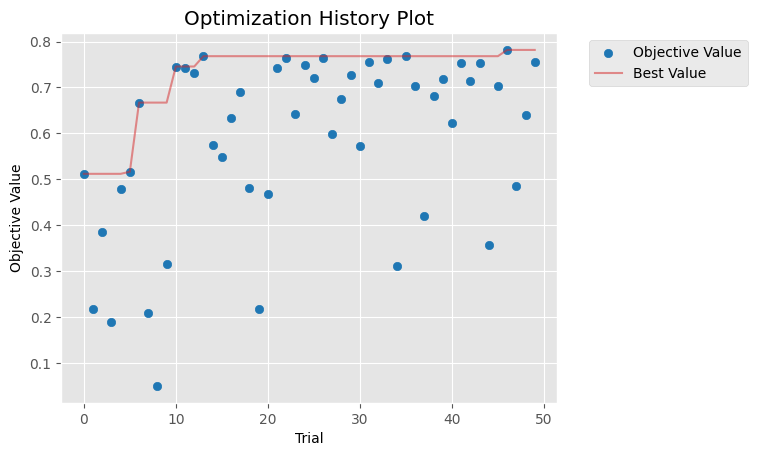

In [38]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_catb_class)

In [39]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_catb_class.trials)))
print('Лучший трайл:')
trial = study_catb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 50
Лучший трайл:
  Лучший F1-score: 0.7816871555743959
  Параметры: 
    iterations: 1000
    learning_rate: 0.0789891831982726
    depth: 10
    l2_leaf_reg: 0.001135114425707057
    random_strength: 6.646392256905374e-08
    bagging_temperature: 6.256377273930235
    od_type: Iter
    od_wait: 12


In [40]:
# with open("models/catb_class_model.pkl", "rb") as f:
#     catb_class = pickle.load(f)

In [41]:
# Обучим модель с полученными параметрами
params = trial.params
catb_class = CatBoostClassifier(verbose=0,**params)
catb_class.fit(X_train, y_train)

# Предсказание
y_pred_catb_class = catb_class.predict(X_test)
f1_catb = f1_score(y_test, y_pred_catb_class)

# Посмотрим на основные метрики качества
print(f"F1-score CatBoost: {round(f1_catb, 3)}")
print('Classification report CatBoost:')
print(classification_report(y_test, y_pred_catb_class))

F1-score CatBoost: 0.782
Classification report CatBoost:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10648
           1       0.92      0.68      0.78      2724

    accuracy                           0.92     13372
   macro avg       0.92      0.83      0.87     13372
weighted avg       0.92      0.92      0.92     13372



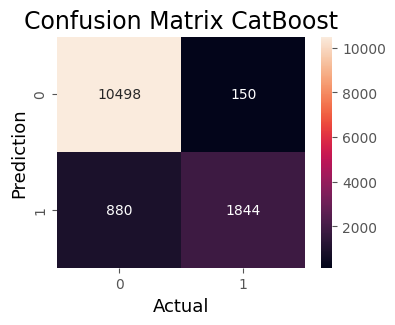

In [42]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_catb = confusion_matrix(y_test, y_pred_catb_class)
sns.heatmap(con_mat_catb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix CatBoost', fontsize=17)
plt.show()

In [43]:
# Сохраним полученную модель
with open(r'models/catb_class_model.pkl', 'wb') as file:
    pickle.dump(catb_class, file)

### XGBoost

In [44]:
def objective_xgb_class(trial):
    """Определение целевой функции для XGBoost Classification"""

    # Подбираемые параметры
    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучение модели
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Предсказание
    y_pred = optuna_model.predict(X_test)

    # Оценка полученного предсказания
    f1 = f1_score(y_test, y_pred)
    return f1

# Создаем сессию для максимизации выбранной метрики
study_xgb_class = optuna.create_study(direction='maximize')
# Запускаем нашу сессию оптимизации
study_xgb_class.optimize(objective_xgb_class, n_trials=50)

[I 2024-05-20 11:29:04,751] A new study created in memory with name: no-name-b695cfad-a5af-4db7-89c2-8881014871cd
[I 2024-05-20 11:29:17,109] Trial 0 finished with value: 0.3577817531305903 and parameters: {'learning_rate': 0.06893868385689765, 'n_estimators': 155, 'max_depth': 4, 'subsample': 0.5622848669285174, 'colsample_bytree': 0.6322677939177987}. Best is trial 0 with value: 0.3577817531305903.
[I 2024-05-20 11:31:04,708] Trial 1 finished with value: 0.5678571428571428 and parameters: {'learning_rate': 0.024758899275989888, 'n_estimators': 799, 'max_depth': 8, 'subsample': 0.828708438210465, 'colsample_bytree': 0.7091194341243368}. Best is trial 1 with value: 0.5678571428571428.
[I 2024-05-20 11:31:13,513] Trial 2 finished with value: 0.4959742351046699 and parameters: {'learning_rate': 0.19202532278634016, 'n_estimators': 113, 'max_depth': 5, 'subsample': 0.9937272945883164, 'colsample_bytree': 0.5948279974321049}. Best is trial 1 with value: 0.5678571428571428.
[I 2024-05-20 11

C:\Users\smart\AppData\Local\Temp\ipykernel_14160\400001077.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_xgb_class)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

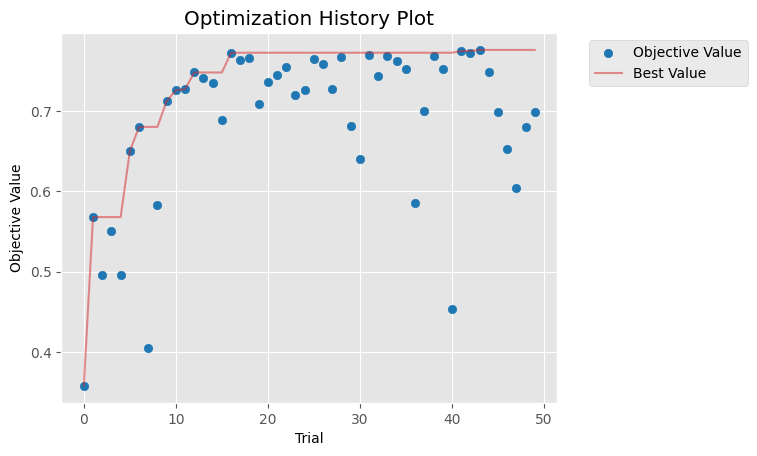

In [45]:
# Посмотрим как проходл процесс подбора параметров на графике
plot_optimization_history(study_xgb_class)

In [46]:
#plot_param_importances(study_xgb_class)

In [47]:
# Посмотрим на итоги подбора параметров
print('Количество завершенных трайлов: {}'.format(len(study_xgb_class.trials)))
print('Лучший трайл:')
trial = study_xgb_class.best_trial

print('  Лучший F1-score: {}'.format(trial.value))
print('  Параметры: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Количество завершенных трайлов: 50
Лучший трайл:
  Лучший F1-score: 0.7758186397984886
  Параметры: 
    learning_rate: 0.1895035710877157
    n_estimators: 936
    max_depth: 9
    subsample: 0.967846921974433
    colsample_bytree: 0.6256307278224831


In [48]:
# with open("models/xgb_class_model.pkl", "rb") as f:
#     xgb_class = pickle.load(f)

In [49]:
# Обучим модель с полученными параметрами
params = trial.params
xgb_class = XGBClassifier(**params)
xgb_class.fit(X_train, y_train)

# Предсказание
y_pred_xgb_class = xgb_class.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb_class)

# Посмотрим на основные метрики качества
print(f"F1-score XGBoost: {round(f1_xgb, 3)}")
print('Classification report XGBoost:')
print(classification_report(y_test, y_pred_xgb_class))

F1-score XGBoost: 0.776
Classification report XGBoost:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10648
           1       0.91      0.68      0.78      2724

    accuracy                           0.92     13372
   macro avg       0.91      0.83      0.86     13372
weighted avg       0.92      0.92      0.92     13372



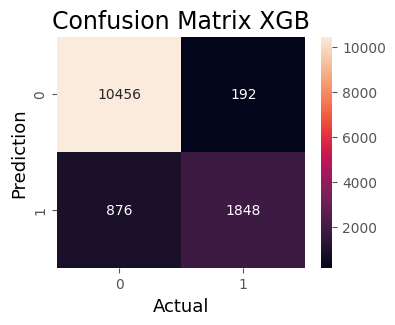

In [50]:
# Потроим матрицу ошибок
plt.figure(figsize=(4, 3))
con_mat_xgb = confusion_matrix(y_test, y_pred_xgb_class)
sns.heatmap(con_mat_xgb,
            annot=True,
            fmt='g'
            )
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix XGB', fontsize=17)
plt.show()

In [51]:
# Сохраним полученную модель
with open(r'models/xgb_class_model.pkl', 'wb') as file:
    pickle.dump(xgb_class, file)

In [52]:
# sns.set_color_codes("muted")

# plt.figure(figsize=(6, 6))
# fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
# lw = 2
# plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
# plt.plot([0, 1], [0, 1])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# #plt.savefig("ROC.png")
# plt.show()